In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation

%matplotlib inline

In [3]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    print files
    songs = []
    for f in tqdm(files):
        print f
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
                print 'gottcha'
            else:
                print np.array(song).shape[0], 'no good'
        except Exception as e:
            raise e    
    return songs

In [4]:
songs = get_songs('./prksn2/') #These songs have already been converted from midi to msgpack
print "{} songs processed".format(len(songs))

  0%|          | 0/5 [00:00<?, ?it/s]

['./prksn2/prksn2_4-copy.mid', './prksn2/prksn2_4.mid', './prksn2/prksn2_1.mid', './prksn2/prksn2_3.mid', './prksn2/prksn2_2.mid']
./prksn2/prksn2_4-copy.mid


 40%|████      | 2/5 [00:02<00:04,  1.54s/it]

gottcha
./prksn2/prksn2_4.mid
1 no good
./prksn2/prksn2_1.mid


 60%|██████    | 3/5 [00:02<00:02,  1.23s/it]

gottcha
./prksn2/prksn2_3.mid


 80%|████████  | 4/5 [00:03<00:00,  1.03it/s]

gottcha
./prksn2/prksn2_2.mid


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

gottcha
4 songs processed


In [5]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 12 #8 #This is the number of timesteps that we will create at a time
n_visible      = 2*note_range #This is the size of the visible layer. 
n_hidden       = 200 #This is the size of the hidden layer
n_output = n_visible
print(n_visible)

156


In [6]:
# reset_graph()
### Model Construction
num_layers = 1 #1
cell = tf.contrib.rnn.BasicRNNCell(n_hidden) # cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_dim)
if num_layers > 1:
    cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers) # cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers) # 
#cell = tf.nn.rnn_cell.DropoutWrapper(cell,output_keep_prob=drop_out)  #optional
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,n_output)

#create placeholders for X and y
X = tf.placeholder(tf.float32, shape=[None, num_timesteps, n_visible])
y = tf.placeholder(tf.float32, shape=[None, num_timesteps, n_output])

batch_size = 1
initial_state = cell.zero_state(batch_size, tf.float32)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32, initial_state = initial_state)
#need to change from default initial_state=None so that the generation of subsequent bars will be continous


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
alpha = 0.001 #01 #0.1
loss = tf.reduce_mean(tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(alpha)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

num_epochs = 100 #00 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.

Iter: 0
Loss: 0.03409
Composition of (48, 156) notes has been completed


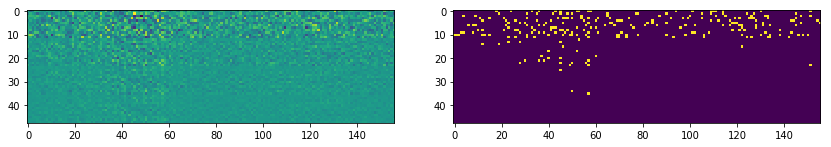

Iter: 10
Loss: 0.01724
Iter: 20
Loss: 0.01579
Iter: 30
Loss: 0.01477
Iter: 40
Loss: 0.01434
Iter: 50
Loss: 0.01417
Iter: 60
Loss: 0.01395
Iter: 70
Loss: 0.01414
Iter: 80
Loss: 0.01424
Iter: 90
Loss: 0.01423
Iter: 100
Loss: 0.01417
Composition of (48, 156) notes has been completed


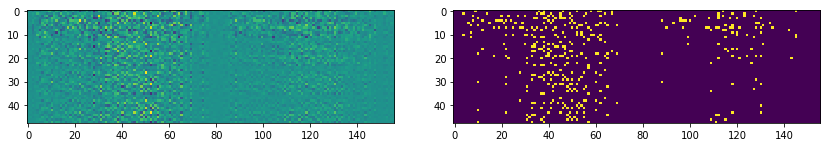

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

somesongs = [songs[0]]
while i <= num_epochs:
    for song in somesongs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        #song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        #song = np.reshape(song, [song.shape[0]/num_timesteps, song.shape[1]*num_timesteps])
        # Train the RBM on batch_size examples at a time
        end_of_song = (np.floor(np.shape(song)[0]/num_timesteps).astype(int)-1)*num_timesteps
        for ind in range(0, end_of_song, num_timesteps): 
            X_train = np.expand_dims(song[ind:ind+num_timesteps], axis = 0)
            y_train = np.expand_dims(song[ind+1:ind+num_timesteps+1], axis = 0)
            _, loss_val = sess.run([training_op, loss], feed_dict={X: X_train, y: y_train})
    
    if i % 10 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss_val))
    if i % 100 == 0:
        next_input = np.random.randn(1,num_timesteps,n_visible)
        #next_input = np.zeros((1,num_timesteps,n_visible))
        n_steps = 4
        samples = np.zeros((1,n_visible))
        #print(np.shape(samples))
        for j in range(n_steps):
            y_pred = sess.run(outputs, feed_dict={X: next_input})
            next_input = y_pred
            #print(np.shape(y_pred))
            samples = np.append(samples,y_pred[0,:,:],axis = 0)

        S = samples[1:]
        print('Composition of {} notes has been completed' . format(np.shape(S)))
        thresh_S = S>=0.5
        plt.figure(figsize=(12,2))
        plt.subplot(1,2,1)
        plt.imshow(S)
        plt.subplot(1,2,2)
        plt.imshow(thresh_S)
        plt.tight_layout()
        plt.pause(0.1)

    i += 1

midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/rnn_generated_chord_{}".format(i))


## Training Ended
# Generative Part Starts Here


In [15]:
#next_input = np.zeros((1,num_timesteps,n_visible))
n_bars = 25*16/num_timesteps
samples = np.zeros((1,n_visible))
y_thought = np.zeros((1,n_hidden))
print(np.shape(y_thought))

(1, 200)


In [18]:
next_input = np.random.randn(1,num_timesteps,n_visible)
for j in range(n_bars):
    y_pred, y_states = sess.run([outputs, states], feed_dict={X: next_input, initial_state: y_thought})
    # next_input = y_pred #this creates loops
    next_input = np.random.randn(1,num_timesteps,n_visible) #reinitialize every num_steps
    y_thought = y_states
    samples = np.append(samples,y_pred[0,:-1,:],axis = 0)

S = samples
print np.shape(S)
thresh_S = S>=0.99 #0.5
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/rnn_generated_chord_long")

(1090, 156)


(588, 156)


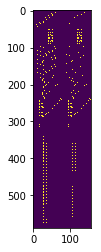

In [19]:
q = "./vf/vf_no4.mid" #No 1, 4 and 6 are triple rhythm 6/8
#q = "./prokofiev_vision_fugitives_22_(c)ungar.mid"
querysong = np.array(midi_manipulation.midiToNoteStateMatrix(q))
print np.shape(querysong)
plt.imshow(querysong)

In [20]:
song = np.array(querysong)
S_reconstruct = song
midi_manipulation.noteStateMatrixToMidi(S_reconstruct, "out/song_reconstruct")   

In [68]:
samples = np.zeros((1,n_visible))
decode_bars = np.shape(song)[0] #check why end_of_song used np.shape(song)[1] ???
print(np.shape(song))
song = np.array(querysong)

end_of_song = (np.floor(np.shape(song)[0]/num_timesteps)-1).astype(int)*num_timesteps
for ind in range(0, end_of_song, num_timesteps): 
    Xq = np.expand_dims(song[ind:ind+num_timesteps], axis = 0)
    #plt.imshow(Xq[0])
    y_pred = sess.run([outputs, feed_dict={X: Xq})

                       
    y_pred, y_states = sess.run([outputs, states], feed_dict={X: next_input, initial_state: y_thought})
    # next_input = y_pred #this creates loops
    next_input = np.random.randn(1,num_timesteps,n_visible) #reinitialize every num_steps
    y_thought = y_states


    #plt.imshow(y_pred[0])
    #print(np.shape(y_pred))
    samples = np.append(samples,y_pred[0,:,:],axis = 0)

(588, 156)


(576, 156)
rnn_generated_query_h200_nt12


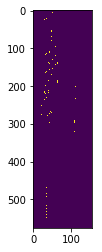

In [69]:
S = samples[1:]
print np.shape(S)
thresh_S = S>=0.6 #0.5
fout = "rnn_generated_query"+'_h'+str(n_hidden)+'_nt'+str(num_timesteps)
print fout
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/"+fout)

plt.imshow(thresh_S)